In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pysentani import *
import sentani as sti
survey = find_survey("../data-anonymous")

../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx


In [14]:
survey['access_type'] = survey['village_name'].apply(lambda x: sti.access_map.get(x))

In [15]:
frequency = {'genset_expenditure':'daily'}

multiplier = {'daily':30}

# creates monthly calculation for genset_expenditure
for column in frequency.keys():
    # adjust expenditure frequency
    expenditure = survey[column] * multiplier[frequency[column]]
    new_column = column + '_monthly'
    survey[new_column] = expenditure
    
# monthly expenditure divided by 960 rp per kWh(.08 USD per kWh * 12000 rp to USD exchange)
# 12000 rp to 1 usd was the exchange rate at time of survey
def genset_kwh_conversion(cv):
    converted = (cv['genset_expenditure_monthly']/(960))
    return converted

survey['genset_kWh'] = survey.apply(genset_kwh_conversion, axis=1)

# kWh multiplied by U.S. EIA estimation of distillate oil(No. 2) CO2 emissions(757.5g/kWh).
# http://www.eia.gov/tools/faqs/faq.cfm?id=74&t=11
def CO2_emission(cv):
    converted = cv['genset_kWh']*757.5 
    return converted

survey['diesel_CO2'] = survey.apply(CO2_emission, axis=1)

# Potential Photovoltaic CO2 production consumption of 105g CO2 per kWh(lifetime) 
# as estimated by BlueSkyModel.org http://blueskymodel.org/kilowatt-hour
def PV_CO2(cv):
    converted = cv['genset_kWh']*105
    return converted

survey['PV_CO2'] = survey.apply(PV_CO2, axis=1)

In [16]:
df = survey.groupby(['access_type'])[['genset_expenditure_monthly','genset_kWh','diesel_CO2','PV_CO2']].sum().dropna()
df.reset_index(inplace=True)
df

,access_type,genset_expenditure_monthly,genset_kWh,diesel_CO2,PV_CO2
0,PLN_grid,17850000,18593.750,1.408477e+07,1952343.750
1,PLN_microgrid,63600000,66250.000,5.018438e+07,6956250.000
2,community_microgrid,4500000,4687.500,3.550781e+06,492187.500
3,no_access,202170120,210593.875,1.595249e+08,22112356.875


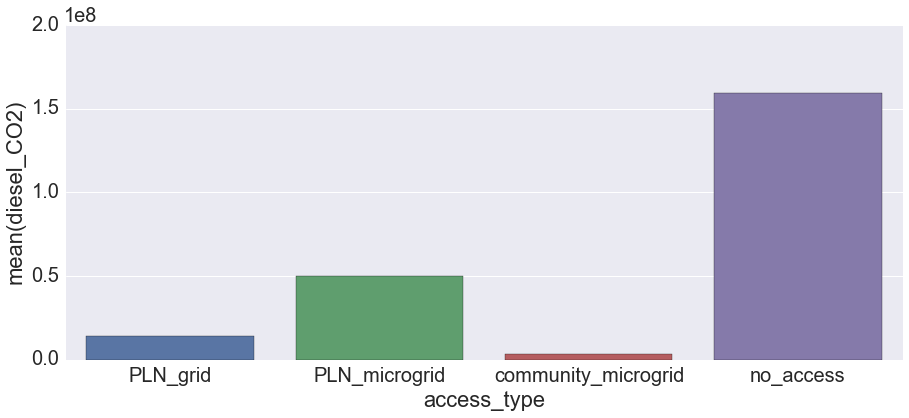

In [17]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x='access_type', y='diesel_CO2',ci=None, data=df)

plt.ylim(0,2e8)
locs, labels = plt.xticks()

### The graph above represents the monthly total of CO2 measured in g/kWh emitted by diesel generators in Lake Sentani, separated by access type. As expected, locations with no access have the highest generator usage and emissions.

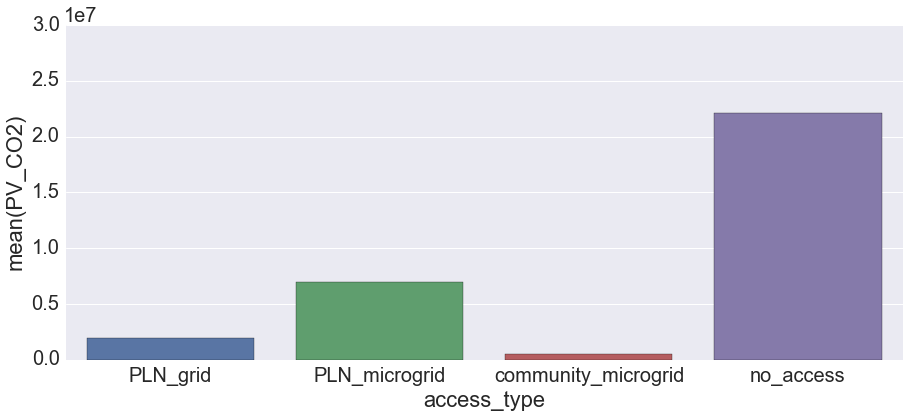

In [18]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x='access_type', y='PV_CO2', ci=None, data=df)

plt.ylim(0,3e7)
locs, labels = plt.xticks()

###This graph represents the amount of CO2 that would be created by PV systems necessary to replace existing diesel generators in Lake Sentani. Measurement is calculated as a monthly total of g/kWh separated by grid type. 

###The calculated reduction would be 86% (105/757.5 = .1386, 1.00 - .1386= .8614). Looking at these graphs it is apparent that the implementation of PV systems to reduce CO2 will have the most impact in locations with no access and those that are on the PLN microgrid. 

### If we are successful in providing complete PV microgrid electrification, we can eliminate approximately 137,000,000 CO2 g/kWh in areas with no access and 43,000,000 CO2 g/kWh in areas with PLN microgrid access on a monthly basis.